In [24]:

import gzip
import math
import numpy as  np
import random
import sklearn
import string
from collections import defaultdict
import json
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def parseData(file):
    for l in open(file,'r'):
        yield json.loads(l)

In [2]:


dataset2 = []
dataset2 = list(parseData('renttherunway_final_data.json'))

dataset2[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [34]:
fit_count = defaultdict(int)
for i in dataset2:
    fit_count[i['fit']]+=1
fit_count

defaultdict(int, {'fit': 142058, 'small': 25779, 'large': 24707})

In [4]:
fittingPerUser = defaultdict(list)
fittingPerItem = defaultdict(list)
allFitting = []
for entry in dataset2:
    item_id = entry['item_id']
    user_id = entry['user_id']
    fit = entry['fit']
    if fit == "fit":
        fit = 3
    elif fit == "small":
        fit = 1
    elif fit == 'large':
        fit = 5
        
    fittingPerUser[user_id].append((item_id,fit))
    fittingPerItem[item_id].append((user_id,fit))
    allFitting.append((user_id, item_id, fit ))

In [5]:

print('Size of the dataset :', len(dataset2))
lengths = []
for u in fittingPerUser:
    lengths.append(len(fittingPerUser[u]))
print("average fitting per user :", np.array(lengths).mean())
print('number of unique users: ', len(lengths))
lengths = []
for i in fittingPerItem:
    lengths.append(len(fittingPerItem[i]))

print("average fitting per item :", np.array(lengths).mean())
print('number of unique items: ', len(lengths))

print('-----------------------------')
print("Remove users with too few reviews")
print('-----------------------------')
removed_user_set = set()
lengths = []
for u in fittingPerUser:
    if len(fittingPerUser[u])>2:
        lengths.append(len(fittingPerUser[u]))
    else:
        removed_user_set.add(u)
        
print("average fitting per user post filterng :", np.array(lengths).mean())
print("total number of users post filtering :", len(lengths))

removed_item_set = set()
lengths = []
for i in fittingPerItem:
    if len(fittingPerItem[i])>2:
        lengths.append(len(fittingPerItem[i]))
    else:
        removed_item_set.add(i)
print("average fitting per item post filterng :", np.array(lengths).mean())
print("total number of items post filtering :", len(lengths))


Size of the dataset : 192544
average fitting per user : 1.8238341968911918
number of unique users:  105571
average fitting per item : 32.91350427350427
number of unique items:  5850
-----------------------------
Remove users with too few reviews
-----------------------------
average fitting per user post filterng : 5.3576835730507195
total number of users post filtering : 15852
average fitting per item post filterng : 36.93733127651369
total number of items post filtering : 5186


In [35]:
users = list(fittingPerUser.keys())
items = list(fittingPerItem.keys())
userIDs = {}
itemIDs = {}
for u,i,r in allFitting:
    # if u in removed_user_set or i in removed_item_set :
    #     continue
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    
random.shuffle(allFitting)
filtered_allFitting = []
for u,i,f in allFitting:
    if u in removed_user_set or i in removed_item_set :
        continue
    filtered_allFitting.append((u,i,f))

filtered_allFitting = allFitting
nTrain = int(len(allFitting)*0.8)
nTest = int(len(allFitting)-nTrain)
interactionsTrain =  allFitting[:nTrain]
interactionsTest = allFitting[nTrain:]

# %%
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(0.003)
mean_rating = np.array([i[2] for i in allFitting]).mean()
print(mean_rating)

class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb1, lamb2):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu,dtype='float32')
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001),dtype='float32')
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001),dtype='float32')
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001),dtype='float32')
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001),dtype='float32')
        self.lamb1 = lamb1
        self.lamb2 = lamb2

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb1 * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2)) +\
                            self.lamb2*(tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

# %%
def trainingStep(model, small, fit, large):
    Nsamples =30000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples//3):

            u,i,r = random.choice(small)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

            u,i,r = random.choice(fit)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)
    
            u,i,r = random.choice(large)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

# %%
modelLFM = LatentFactorModel(mean_rating, 5, 0.000008,0.000038)

# spliting the training based on fit:

small, fit, large = [], [], []

for u,i,r in interactionsTrain:
    if r == 1:
        small.append((u,i,r))
    elif r == 3:
        fit.append((u,i,r))
    elif r == 5:
        large.append((u,i,r))

for i in range(700):
    obj = trainingStep(modelLFM, small, fit,large)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))



2.988864882831976
iteration 10, objective = 1.2945192
iteration 20, objective = 1.2514488
iteration 30, objective = 1.209281
iteration 40, objective = 1.1675289
iteration 50, objective = 1.1291025
iteration 60, objective = 1.0884085
iteration 70, objective = 1.048727
iteration 80, objective = 1.0054245
iteration 90, objective = 0.9693226
iteration 100, objective = 0.9309399
iteration 110, objective = 0.8941638
iteration 120, objective = 0.86122066
iteration 130, objective = 0.82878053
iteration 140, objective = 0.8001401
iteration 150, objective = 0.7696608
iteration 160, objective = 0.75292265
iteration 170, objective = 0.726797
iteration 180, objective = 0.7115574
iteration 190, objective = 0.6923141
iteration 200, objective = 0.67905027
iteration 210, objective = 0.6632082
iteration 220, objective = 0.6479116
iteration 230, objective = 0.6398601
iteration 240, objective = 0.6275546
iteration 250, objective = 0.6177148
iteration 260, objective = 0.60869396
iteration 270, objective = 

In [36]:
for i in range(700):
    obj = trainingStep(modelLFM, small, fit,large)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 10, objective = 0.46623516
iteration 20, objective = 0.46834242
iteration 30, objective = 0.46707368
iteration 40, objective = 0.4645946
iteration 50, objective = 0.46429104
iteration 60, objective = 0.4619119
iteration 70, objective = 0.4648081
iteration 80, objective = 0.46288386
iteration 90, objective = 0.4630081
iteration 100, objective = 0.45846945
iteration 110, objective = 0.46189186
iteration 120, objective = 0.45663548
iteration 130, objective = 0.45762062
iteration 140, objective = 0.4573614
iteration 150, objective = 0.45636338
iteration 160, objective = 0.4578599
iteration 170, objective = 0.4593971
iteration 180, objective = 0.45475304
iteration 190, objective = 0.45522654
iteration 200, objective = 0.4514019
iteration 210, objective = 0.45677733
iteration 220, objective = 0.45449144
iteration 230, objective = 0.45465434
iteration 240, objective = 0.45449635
iteration 250, objective = 0.45571035
iteration 260, objective = 0.4512171
iteration 270, objective = 0.4

In [ ]:
for i in range(2):
    obj = trainingStep(modelLFM, interactionsTrain)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

In [37]:
def out_to_fit(x):
    if x <=2:
        return 1
    elif x <= 4:
        return 3
    else:
        return 5
correct = 0 
for u,i,f in interactionsTest:
    if f == out_to_fit(modelLFM.predict(userIDs[u],itemIDs[i]).numpy()):
        correct += 1 

print(correct / len(interactionsTest))


0.708561634942481


In [38]:
def average_auc_score(test):
    pred = []
    target = []

    for u,i,f in test:
        pred.append(modelLFM.predict(userIDs[u],itemIDs[i]).numpy())
        target.append(f)

    pred_prob = np.zeros((len(test),3))
    for val_ind in range(len(pred)):
        val = pred[val_ind]
        prob1 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-1)/0.85)**2)
        prob2 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-3)/0.85)**2)
        prob3 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-5)/0.85)**2)
        sum_ = prob1 + prob2 + prob3

        pred_prob[val_ind][0] = prob1/sum_
        pred_prob[val_ind][1] = prob2/sum_
        pred_prob[val_ind][2] = prob3/sum_
    AUC = []
    target_map = [1,3,5]
    legend_map = ['small','fit','large']
    for i in range(3):
        target_sp = []
        for t in target: 
            if t == target_map[i]:
                target_sp.append(1)
            else:
                target_sp.append(0)
        AUC.append(roc_auc_score(target_sp, pred_prob[:,i], average='weighted'))

        fpr, tpr, thresholds = roc_curve(target_sp, pred_prob[:,i])
        plt.plot(fpr, tpr, label=legend_map[i])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('AUC.png')

    return np.mean(np.array(AUC))


0.7258207337262667

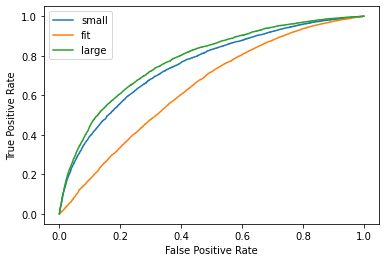

In [39]:
average_auc_score(interactionsTest)